In [1]:
import nltk   
import spacy            
import re     
import string            
import numpy as np
import pandas as pd
import random
import collections
import time
import matplotlib.pyplot as plt
from nltk.corpus import twitter_samples    # Corpus Twitter
from nltk.tokenize import word_tokenize 
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Lectura de Corpus

In [2]:
nltk.download('twitter_samples')

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


True

In [3]:
pos_tweets = twitter_samples.strings('positive_tweets.json') #tweets positivos
neg_tweets = twitter_samples.strings('negative_tweets.json') #tweets negativos

print("Positive tweets: ", len(pos_tweets))
print("Negative tweets: ", len(neg_tweets))

Positive tweets:  5000
Negative tweets:  5000


Preprocesamiento


1. LowerCase
2. Lematización / Stemming
3. Remover stopword
4. Remover signos de puntuación
4. Remover urls y manejadores





In [4]:
def custom_tokenizer(nlp):
    special_cases = {":)": [{"ORTH": ":)"}], ":(": [{"ORTH": ":("}]}
    simple_url_re = re.compile(r'''^https?://''')
    suffixes = nlp.Defaults.suffixes + [r'''-+$''',]
    suffix_regex = spacy.util.compile_suffix_regex(suffixes)
    return spacy.tokenizer.Tokenizer(nlp.vocab, rules=special_cases, suffix_search=suffix_regex.search, url_match=simple_url_re.match)

nlp = spacy.load("en_core_web_sm")
nlp.tokenizer = custom_tokenizer(nlp)


In [5]:
def normalization(data, regularization="lemma", language='english'):
  stopwords = nltk.corpus.stopwords.words(language)
  ps = PorterStemmer()
  normalized_data = []
  
  for tweet in data:
    tweet = re.sub(r'^RT[\s]+', '', tweet) # identificar retweets
    tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet) #eliminar links
    tweet = re.sub(r'#', '', tweet) #eliminar símbolo gato
    tweet = re.sub(r'@\w+', '', tweet) #eliminar palabras que inicias con @
    tweet = re.sub(r'\d+', '', tweet) #eliminar números
    tweet = re.sub(' +', ' ', tweet) #quitar espacios

    if regularization == "stem":
      tweetTokenizer = TweetTokenizer()
      words = tweetTokenizer.tokenize(tweet)
      tokens = [ps.stem(w) for w in words]
    if regularization == "lemma":
      doc = nlp(tweet)
      tokens = [token.lemma_ for token in doc]
    else:
      doc = nlp(tweet)
      tokens = [token.text for token in doc]
    
    normalized_tweets = [w.lower() for w in tokens if w.lower() not in stopwords and not w==' ' and w not in string.punctuation]
    normalized_data.append(normalized_tweets)
  return normalized_data

Create Vocabulary and frequency dictionaries

In [6]:
norm_pos = normalization(pos_tweets)
norm_neg = normalization(neg_tweets)
all_tweets = norm_pos + norm_neg


In [7]:
def n_grams(words:list, n_gram:int):
  if int(n_gram) == 1: return words
  return [tuple(words[i:i+int(n_gram)]) for i,w in enumerate(words) if i <= (len(words)-int(n_gram))]

In [8]:
ngrams = 2
n_grams_tweets = [n_grams(tweet, ngrams) for tweet in all_tweets]
at = [w for tweet in n_grams_tweets for w in tweet]
fd = nltk.FreqDist(at)
vocabulary = sorted(list(fd.keys()))

print('\nThe vocabulary has ' + str(len(vocabulary)) + ' ' + str(ngrams) + '-grams.\n')


The vocabulary has 40796 2-grams.



In [9]:
X_features = []
for text in n_grams_tweets:
  vector = [] # initialize in 1 ?
  for voc in vocabulary:
    # In vector saves a list of vocabulary's length. 
    # Iterate each vocabulary word and count in each text list
    vector.append(text.count(voc))
  X_features.append(vector)

print('\nX_features matrix has m = %d examples (rows).\n' %len(X_features))
print('and  n = %d features (columns).\n' %len(X_features[0]))


X_features matrix has m = 10000 examples (rows).

and  n = 40796 features (columns).



In [10]:
tags = [1]*len(pos_tweets) + [0]*len(neg_tweets)

In [11]:
from sklearn.decomposition import PCA

In [47]:
pca = PCA(n_components=1000)
pca.fit(X_features)
X_features_pca = pca.transform(X_features)


In [48]:
#print(pca.explained_variance_ratio_)
n_components = 500
suma = np.sum(pca.explained_variance_ratio_[:n_components])
print("Perdida de información es de : " + str(round(1-suma,4)) + " %")

Perdida de información es de : 0.7242 %


In [11]:
#Principal component analysis
def compute_pca(X, k_components=2, tolerance=0.01):
    """
    Entrada:
        X: Dimensión (m,n) donde n son las características y m son los ejemplos
        k_components: Number of components you want to keep.
    Salida:
        X_reduced: Datos transformados con k_components dimensiones
    """

    # Centrar los datos de entrada a su media
    X_demeaned = X - np.mean(X, axis=0, keepdims=True)

    # Calcula la matriz de covarianza
    covariance_matrix = np.cov(X_demeaned, rowvar=False)

    # Calcula los eigenvectores y eigenvalores de la matriz de covarianza
    eigen_vals, eigen_vecs = np.linalg.eigh(covariance_matrix, UPLO='L')

    # Retorna los índices que ordenarían los eigenvalores de mayor a menor
    idx_sorted = np.argsort(-eigen_vals)

    # Ordena los eigenvalores por idx_sorted
    eigen_vals_sorted = eigen_vals[idx_sorted]

    # Ordena los eigenvectores usando los indices idx_sorted 
    eigen_vecs_sorted = eigen_vecs[:,idx_sorted]

    # Selecciona los primeros k eigenvectores
    eigen_vecs_subset = eigen_vecs_sorted[:,0:k_components]

    # Selecciona los primeros k eigenvalores
    eigen_vals_subset = eigen_vals_sorted[:k_components]

    # Calcula la pérdida de información (Varianza), un numero aceptable es < 0.01
    variance = 1 - (sum(eigen_vals_subset) / sum(eigen_vals))
    if variance <= tolerance:
        print("Pérdida de información aceptable")
    else:
        print("PÉRDIDA DE INFORMACIÓN IMPORTANTE - AUMENTA K-COMPONENTS")

    print("Porcentaje de pérdida de información del " + str(abs(round(1 - (variance*100), 4))) + "%")

    # Transforma los datos, por la multiplicación de la transpuesta de los eigenvectores
    # con la transpuesta de los datos de entrada centrados a su media
    X_reduced = np.matmul(eigen_vecs_subset.T, X_demeaned.T)
    X_reduced = X_reduced.T

    return X_reduced

In [ ]:
X_features_pca = compute_pca(X_features, k_components=500)

In [49]:
"""Shuffle list"""
tuple_list = list(zip(X_features_pca, tags)) #list of tuples (X,y)
random.seed(30)
random.shuffle(tuple_list)
X_, y_ = zip(*tuple_list)

X = list(X_)
y = list(y_)

In [50]:
"""split corpus into test(20%) and train(80%)"""
test_percentage = 0.2
split = int(len(X) * test_percentage)
X_test = X[:split]
y_test = y[:split]
X_train = X[split:]
y_train = y[split:]

m_train = len(X_train) #number of examples in X_train
m_test = len(X_test) #number of examples in X_test
n = len(X_train[0]) #features

In [51]:
"""Convert to array"""
import numpy as np
X_train = np.array(X_train).T
X_test = np.array(X_test).T
y_train = np.array(y_train)
y_test = np.array(y_test)
print('features: ', n)
print('shape X_train: ', X_train.shape)
print('shape X_test: ', X_test.shape)

y_train = y_train.reshape((m_train, 1))
y_test = y_test.reshape((m_test, 1))
print('shape y_train: ', y_train.shape)
print('shape y_test: ', y_test.shape)

features:  1000
shape X_train:  (1000, 8000)
shape X_test:  (1000, 2000)
shape y_train:  (8000, 1)
shape y_test:  (2000, 1)


In [52]:
def sigmoid(z):
  sigmoide = np.where(z < 0, np.exp(z)/(1 + np.exp(z)), 1/(1 + np.exp(-z)))
  return sigmoide
  #return 1/(1 + np.exp(-z)) 

In [53]:
def log_loss(y_true, y_pred):
    eps = 1e-15
    y_pred = np.clip(y_pred, eps, 1 - eps) #limitar los valores del array en el rango eps y 1 - eps
    loss = - y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred)
    return np.mean(loss)

In [54]:
def gradient_descent(h_theta, y, X):
  return (1/len(y)) * np.dot((h_theta - y).T,X.T) # 1xm dot mxn ->1xn

In [55]:
""" Train """
epochs = 2000
learning_rate = 8
costs = []
theta = np.zeros((n,1)) #-> nx1

start_time = time.time()
for i in range(epochs):
  z = np.dot(theta.T, X_train) #->1xm
  h_theta = sigmoid(z.T)#->mx1, h_theta or y_pred
  #Calculate cost
  cost = log_loss(y_train,h_theta) #scalar
  costs.append(cost)

  if i%100 == 0:
    print('Cost in epoch', i, 'is', cost)
    
  #Gradient descent
  d_theta = gradient_descent(h_theta, y_train, X_train).T #->nx1
  theta = theta - learning_rate * d_theta #->nx1


end_time = time.time()
epoch_time = end_time - start_time
print("Execution time : {:.2f} seconds".format(epoch_time))
  

Cost in epoch 0 is 0.6931471805599454
Cost in epoch 100 is 0.518970971568559
Cost in epoch 200 is 0.46865282373718153
Cost in epoch 300 is 0.4413016072824165
Cost in epoch 400 is 0.42356690142836606
Cost in epoch 500 is 0.41090816119597195
Cost in epoch 600 is 0.401299603283691
Cost in epoch 700 is 0.3936865359700201
Cost in epoch 800 is 0.3874604611830561
Cost in epoch 900 is 0.3822433150518283
Cost in epoch 1000 is 0.3777866087593281
Cost in epoch 1100 is 0.3739196175505814
Cost in epoch 1200 is 0.37052076014007734
Cost in epoch 1300 is 0.3675008458988741
Cost in epoch 1400 is 0.3647927928994879
Cost in epoch 1500 is 0.36234506272895917
Cost in epoch 1600 is 0.36011732533699675
Cost in epoch 1700 is 0.35807751250886366
Cost in epoch 1800 is 0.3561997641754401
Cost in epoch 1900 is 0.3544629650594899
Execution time : 17.80 seconds


Text(0.5, 1.0, 'Learning curve')

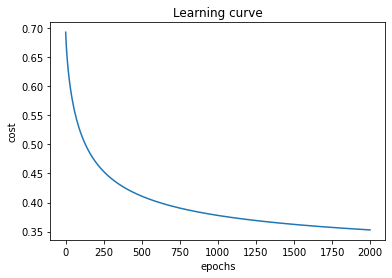

In [56]:
#Plot train cost
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('epochs')
plt.title("Learning curve")

In [57]:
def evaluation(theta,X):
  #X -> nxm
  #theta.T ->1xn
  z = np.dot(theta.T, X) #->1xm
  return sigmoid(z.T)#->mx1

In [58]:
def classify_tag(y_pred_list,threshold):
  return [1 if y >= threshold else 0 for y in y_pred_list]

In [59]:
def confusion_matrix_values(y_pred, y_label):
  TP, FN, FP, TN = 0 , 0 , 0, 0
  for i in range(len(y_pred)):
    if y_pred[i] == 1 and  y_label[i] == 1:
      TP = TP + 1
    elif y_pred[i] == 1 and y_label[i] == 0:
      FP = FP + 1
    elif y_pred[i] == 0 and y_label[i] == 1:
      FN = FN + 1
    else:
      TN = TN + 1
  return TP, FN, FP, TN

In [60]:
"""Measures"""

def measures(TP, FN, FP, TN):
  accuracy = (TP + TN) / (TP + TN + FP + FN)
  fallout = FP / (FP + TN)
  precision = TP / (TP + FP)
  recall = TP / (TP + FN)
  F = (precision * recall) / (precision + recall)
  F1 = (2 * precision * recall)/(precision + recall)
  print("Presicion: ", precision)
  print("Recall: ", recall)
  print("F: ", F)
  print("F1: ", F1)
  print("Fallout: ", fallout)
  print("Accuracy: ", accuracy)

In [61]:
"""Evaluation for Train"""

threshold = 0.5
y_train_pred_prob = evaluation(theta,X_train)
y_train_pred = classify_tag(y_train_pred_prob, threshold) #Classify to 0 (ham) or 1 (spam)
TP, FN, FP, TN = confusion_matrix_values(y_train_pred, y_train)
print(TP,FN,FP,TN)
measures(TP,FN,FP,TN)

2779 1206 278 3737
Presicion:  0.9090611710827609
Recall:  0.6973651191969887
F:  0.3946322067594434
F1:  0.7892644135188868
Fallout:  0.06924034869240349
Accuracy:  0.8145


In [62]:
"""Evaluation for Test"""

y_test_pred_prob = evaluation(theta,X_test)
y_test_pred = classify_tag(y_test_pred_prob, threshold)
TP, FN, FP, TN = confusion_matrix_values(y_test_pred, y_test)
print(TP,FN,FP,TN)
measures(TP,FN,FP,TN)

620 395 115 870
Presicion:  0.8435374149659864
Recall:  0.6108374384236454
F:  0.3542857142857143
F1:  0.7085714285714286
Fallout:  0.116751269035533
Accuracy:  0.745


Usando scikit-learn

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_features_pca,y,test_size=0.2, random_state=50)
target_names = ['class 0', 'class 1']

In [65]:
# Creamos el modelo de regresión logística
modelo = LogisticRegression()
# Entrenamos el modelo con los datos de entrenamiento
modelo.fit(X_train, y_train)
predicciones = modelo.predict(X_test)
# Evaluamos el modelo
puntaje = modelo.score(X_test, y_test)
# Imprimimos el puntaje obtenido
print("Puntaje: ", puntaje)
print(classification_report(y_test, predicciones, target_names=target_names, digits=4))

Puntaje:  0.5095
              precision    recall  f1-score   support

     class 0     0.5016    0.6264    0.5571       985
     class 1     0.5221    0.3961    0.4504      1015

    accuracy                         0.5095      2000
   macro avg     0.5119    0.5112    0.5038      2000
weighted avg     0.5120    0.5095    0.5030      2000

